<a href="https://colab.research.google.com/github/IlyaZutler/Project_2-Trucks/blob/main/DM%20_%20Project_3_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic mitochondria Project - Heavy Machinery Auction Price Estimator


In [ ]:
import gdown
from pathlib import Path

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

!pip -qq install category_encoders
from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
def download_from_gdrive(url, filename):
    # Extract the file ID from the URL
    file_id = url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download the file
    if Path(filename).exists():
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        gdown.download(download_url, filename, quiet=False)
        print(f"File downloaded as: {filename}")

train = 'https://drive.google.com/file/d/1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5/view?usp=drive_link'
valid = 'https://drive.google.com/file/d/1j7x8xhMimKbvW62D-XeDfuRyj9ia636q/view?usp=drive_link'
# Example usage

download_from_gdrive(train, 'train.csv')
download_from_gdrive(valid, 'valid.csv')

df = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')


Downloading...
From (original): https://drive.google.com/uc?id=1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5
From (redirected): https://drive.google.com/uc?id=1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5&confirm=t&uuid=bc7611e2-b5e5-4b27-9e09-c7e59f68992c
To: /content/train.csv
100%|██████████| 116M/116M [00:02<00:00, 46.7MB/s]


File downloaded as: train.csv


Downloading...
From: https://drive.google.com/uc?id=1j7x8xhMimKbvW62D-XeDfuRyj9ia636q
To: /content/valid.csv
100%|██████████| 3.32M/3.32M [00:00<00:00, 19.3MB/s]


File downloaded as: valid.csv


<ipython-input-2-861d4f7287ed>:20: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


## Exploratory Data Analysis (EDA)

In [ ]:
#df.fiProductClassDesc.value_counts()

In [ ]:
#df.info()

In [ ]:
# df.isnull().sum()

In [ ]:
#df.describe()

In [ ]:
#sns.histplot(data=df, x='SalePrice', bins=20)

In [ ]:
# to see value_counts for all categorical columns, but some realy categorical columns has numerical type like ModelID
categorical_cols = df.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' in TRAIN DF :")
  print(df[col].value_counts())
  print(f"NaN values in Train: {df[col].isnull().sum()} ")
  print()
  print(f"Value counts for column '{col}' in VALID :")
  print(df_valid[col].value_counts())
  print()
  print(f"NaN values in Valid :{df_valid[col].isnull().sum()} ")
  print()
  print()

Value counts for column 'datasource' in TRAIN DF :
datasource
132    260752
136     75491
149     26304
121     23979
172     14599
Name: count, dtype: int64
NaN values in Train: 0 

Value counts for column 'datasource' in VALID :
datasource
149    7021
172    3315
121    1212
132      24
173       1
Name: count, dtype: int64

NaN values in Valid :0 


Value counts for column 'UsageBand' in TRAIN DF :
UsageBand
Medium    33985
Low       23620
High      12034
Name: count, dtype: int64
NaN values in Train: 331486 

Value counts for column 'UsageBand' in VALID :
UsageBand
Medium    1847
Low       1691
High       493
Name: count, dtype: int64

NaN values in Valid :7542 


Value counts for column 'fiModelDesc' in TRAIN DF :
fiModelDesc
310G        5039
416C        4869
580K        4315
310E        4233
140G        4083
            ... 
EX210-5        1
KX025          1
EX120-5F       1
EX100-5E       1
HW180          1
Name: count, Length: 4999, dtype: int64
NaN values in Train: 0 

Value c

### 3. Data Preprocessing

In [ ]:
def fix_mistakes(X, replacement_dict):
    for col, replacements in replacement_dict.items():
        X[col] = X[col].replace(replacements)
    return X

fix_mistakes(df, replacement_dict = {'Transmission': {'AutoShift': 'Autoshift'}})
fix_mistakes(df_valid, replacement_dict = {'Transmission': {'AutoShift': 'Autoshift'}})

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1222837,902859,1376,121,3,1000,0.0,NaN,1/5/2012 0:00,375L,375,NaN,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 66.0 to 90.0 Metr...",Kentucky,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,1/5/2012 0:00,TX300LC2,TX300,LC,2,NaN,Large / Medium,"Hydraulic Excavator, Track - 28.0 to 33.0 Metr...",Connecticut,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,Hydraulic,NaN,NaN,NaN,Steel,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN
2,1222841,999308,4587,121,3,2000,10127.0,Medium,1/5/2012 0:00,270LC,270,NaN,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 24.0 to 28.0 Metr...",Connecticut,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1222843,1062425,1954,121,3,1000,4682.0,Low,1/5/2012 0:00,892DLC,892,D,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 28.0 to 33.0 Metr...",Connecticut,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,1/4/2012 0:00,544H,544,H,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,6333344,1919201,21435,149,2,2005,NaN,NaN,3/7/2012 0:00,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Texas,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
11569,6333345,1882122,21436,149,2,2005,NaN,NaN,1/28/2012 0:00,30NX2,30,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
11570,6333347,1944213,21435,149,2,2005,NaN,NaN,1/28/2012 0:00,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
11571,6333348,1794518,21435

In [ ]:
def fix_data(X, date_col):
    for col in date_col:
        X[col] = pd.to_datetime(X[col])
        X[col + '_Year'] = X[col].dt.year
        X[col + '_Month'] = X[col].dt.month
        X = X.drop(col, axis=1)
    return X

df = fix_data(df, date_col = ['saledate'])
df_valid = fix_data(df_valid, date_col = ['saledate'])

In [ ]:
# null or 0 indicates no hours reported. make Nan from 0

df.MachineHoursCurrentMeter.replace(0, np.nan, inplace=True)
df_valid.MachineHoursCurrentMeter.replace(0, np.nan, inplace=True)

In [ ]:
# There are many cars with the year of manufacture 1000. Let's make it so that when calculating their age is -1000.

df.loc[df['YearMade'] == 1000, 'YearMade'] = df['saledate_Year'] - 1000
df_valid.loc[df_valid['YearMade'] == 1000, 'YearMade'] = df_valid['saledate_Year'] - 1000

df['age_car'] = df['saledate_Year'] - df['YearMade']
df_valid['age_car'] = df_valid['saledate_Year'] - df_valid['YearMade']

# All sales in Valid are for 2012. But in Train they are up to 2011. We will forecast them for 2011.
#df_valid['saledate_Year'] = df_valid['saledate_Year'] - 1   # for tree this is not necessary

In [ ]:
def first_word_name(X, col):
    for col_ in col:
        X[col_+'_first_word'] = X[col_].apply(lambda x: x.split()[0] if isinstance(x, str) else x)
    return X

first_word_name(df, col = ['fiProductClassDesc'])
first_word_name(df_valid, col = ['fiProductClassDesc'])

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_Year,saledate_Month,age_car,fiProductClassDesc_first_word
0,1222837,902859,1376,121,3,1012,NaN,NaN,375L,375,NaN,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 66.0 to 90.0 Metr...",Kentucky,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,1,1000,Hydraulic
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,TX300LC2,TX300,LC,2,NaN,Large / Medium,"Hydraulic Excavator, Track - 28.0 to 33.0 Metr...",Connecticut,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,Hydraulic,NaN,NaN,NaN,Steel,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN,2011,1,6,Hydraulic
2,1222841,999308,4587,121,3,2000,10127.0,Medium,270LC,270,NaN,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 24.0 to 28.0 Metr...",Connecticut,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,1,12,Hydraulic
3,1222843,1062425,1954,121,3,1012,4682.0,Low,892DLC,892,D,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 28.0 to 33.0 Metr...",Connecticut,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,1,1000,Hydraulic
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,544H,544,H,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2011,1,10,Wheel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,6333344,1919201,21435,149,2,2005,NaN,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Texas,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,3,7,Hydraulic
11569,6333345,1882122,21436,149,2,2005,NaN,NaN,30NX2,30,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,1,7,Hydraulic
11570,6333347,1944213,21435,149,2,2005,NaN,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,N

In [ ]:
def ord_encod_nan(X, col, categories):
    encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value= -1)
    X[col + '_3'] = encoder.fit_transform(X[[col]])
    X[col + '_3'].replace(-1, np.nan, inplace=True)
    X[col + '_3'] = pd.to_numeric(X[col + '_3'], errors='coerce')
    X[col + '_3'] = X[col + '_3'].astype('float')

    return X

df = ord_encod_nan(df, col = 'UsageBand', categories = ['Low', 'Medium', 'High'])
df_valid = ord_encod_nan(df_valid, col = 'UsageBand', categories = ['Low', 'Medium', 'High'])

df = ord_encod_nan(df, col = 'ProductSize', categories = ['Mini', 'Compact', 'Small', 'Medium', 'Large / Medium', 'Large', 'High'])
df_valid = ord_encod_nan(df_valid, col = 'ProductSize', categories = ['Mini', 'Compact', 'Small', 'Medium', 'Large / Medium', 'Large', 'High'])

In [ ]:
def replace_dict(X, col, repl_dict):
    new_name = col + '_3'

    X[new_name] = X[col]
    for old, new in repl_dict.items():
        X[new_name] = X[new_name].str.replace(old, new, regex=False)
    X[new_name].replace('None or Unspecified', -1)
    X[new_name].replace(-1, np.nan, inplace=True)
    X[new_name] = pd.to_numeric(X[new_name], errors='coerce')
    X[new_name] = X[new_name].astype('float')

    return X

df = replace_dict(df, col = 'Undercarriage_Pad_Width', repl_dict= {' inch': ''})
df_valid = replace_dict(df_valid, col= 'Undercarriage_Pad_Width', repl_dict = {' inch': ''})

df = replace_dict(df, col = 'Stick_Length', repl_dict= {"' ": '.', '"': ''})
df_valid = replace_dict(df_valid, col= 'Stick_Length', repl_dict = {"' ": '.', '"': ''})

In [ ]:
## there are categorical variables, but they are coded by numbers. let's make them "object"

def Num_to_Object(X, col):
    for col_ in col:
        X[col] = X[col].astype('object')
    return X

df = Num_to_Object(df, col = ['datasource'])
df_valid = Num_to_Object(df_valid, col = ['datasource'])

# Targen Encoding

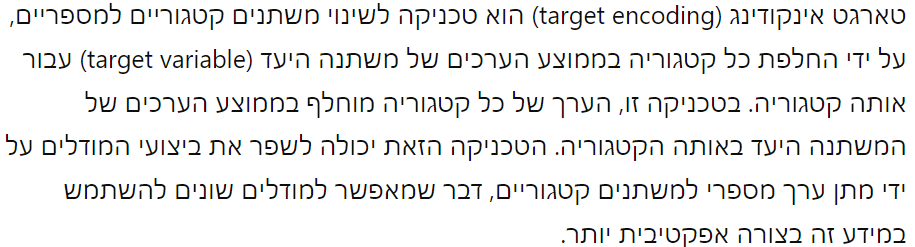

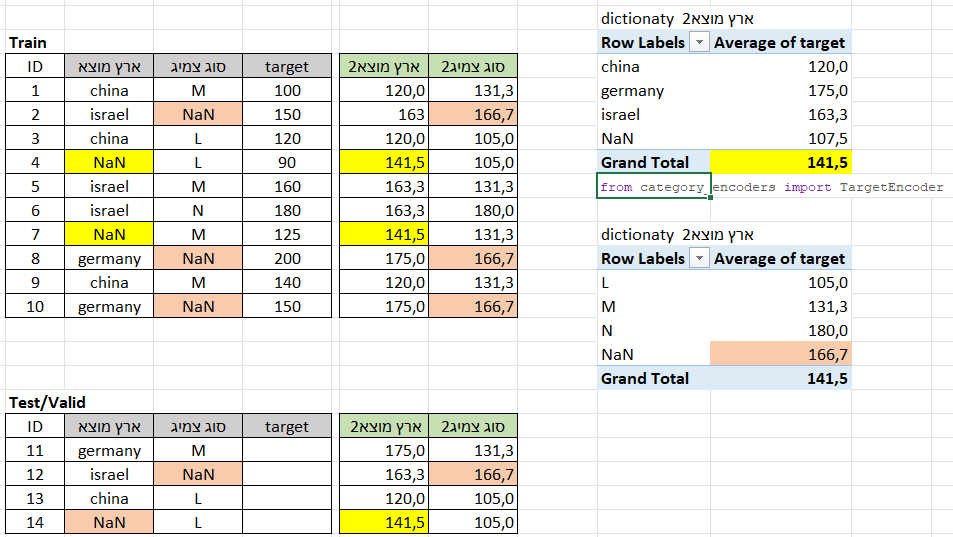

In [ ]:
### This class handles NaN differently. NaN values ​​are mapped to the average Target values ​​for NaN!!!

#class MeanNanTargetEncoder():
#     def fit(self, X, y):
#         self.target_mean_dict = dict()
#         self.target_nan_mean_dict = dict()

#         y = pd.DataFrame(y)
#         X = pd.concat([X, y], axis=1)
#         X = X.rename(columns={0: 'Target'})

#         for col in X.select_dtypes(exclude='number').columns:
#             self.target_mean_dict[col] = X.groupby(col)['Target'].mean().to_dict()
#             self.target_nan_mean_dict[col] = X[X1[col].isna()]['Target'].mean()
#
#         X = X.drop(columns=['Target'])

#         return self

#     def transform(self, X):
#         for col in X.select_dtypes(exclude='number').columns:
#             X[col] = X[col].map(self.target_mean_dict[col]).fillna(self.target_nan_mean_dict[col])
#             X[col] = X[col].astype(float)

#         return X


# Train - Tast

In [ ]:
df2 = df.sample(401125, random_state=57) #401125

y = df2[['SalePrice']]
X = df2.drop(columns= ['SalePrice', 'SalesID', 'MachineID', 'ModelID', 'datasource'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

obj_col = X_train.select_dtypes(exclude='number').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=3,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), obj_col),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', RandomForestRegressor(n_jobs=-1,
                              n_estimators = 300,
                              #max_depth = 12,
                              min_impurity_decrease = 0.1,
                              #min_samples_split = 3,
                              max_features = 9,
                              random_state = 142
                              ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'R²:' , r2_score(y_test, y_test_pred))
print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Train RMSE: 2560.4095926100886
Test RMSE: 6795.032921405196
R²: 0.9134479518133194
Train MAE: 1624.7444634741828
Test MAE: 4226.191583589743


## Train - Valid

In [ ]:
# y_train = df[['SalePrice']]
# X_train = df.drop(columns= ['SalePrice', 'SalesID', 'MachineID', 'ModelID', 'datasource'])

# X_test = df_valid

# col_train_num = X_train.select_dtypes('number').columns
# col_test_num = X_test.select_dtypes('number').columns

# X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
# X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

# obj_col = X_train.select_dtypes(exclude='number').columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('mean_target_encode', TargetEncoder(
#                                              min_samples_leaf=3,
#                                              #smoothing=10,
#                                              handle_missing='value',
#                                              handle_unknown='value'
#         ), obj_col),  # Применение TargetEncoder к столбцу 'category'
#      ],
#     remainder='passthrough'  # Оставляет остальные столбцы без изменений
# )

# pipeline = Pipeline([
#                     ('preprocessor', preprocessor
#                      ),

#                     ('model', RandomForestRegressor(n_jobs=-1,
#                               n_estimators = 300,
#                               #max_depth = 12,
#                               min_impurity_decrease = 0.1,
#                               #min_samples_split = 3,
#                               max_features = 9,
#                               random_state = 142
#                               ))
# ])

# pipeline.fit(X_train, y_train)

# y_train_pred = pipeline.predict(X_train)
# y_valid_pred = pipeline.predict(df_valid)


# print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
# print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))


In [ ]:
#### Trees cannot interpolate.
### If in 2009 the price was 10,000, in 2010 the price was 11,000, and in 2011 the price was 12,000,
### then for 2012 the forecast will only be 12,000.
### Here we make a manual adjustment for inflation.

#y_valid_pred = y_valid_pred *1.035

In [ ]:
# # Create a submission file
# submission = pd.DataFrame({'SalesID': df_valid['SalesID'], 'SalePrice': y_valid_pred})
# submission.to_csv('final_submission.csv', index=False)